In [31]:
#!pip3 install tensorflow==2.4.1

In [77]:
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout

from matplotlib import pyplot as plt

In [68]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

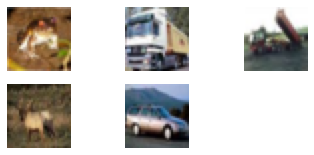

In [73]:
for i in range(5):
	plt.subplot(3, 3, 1 + i)
	plt.axis('off')
	plt.imshow(X_train[i])
plt.show()

In [4]:
X_train.shape

(50000, 32, 32, 3)

In [5]:
# Modifiy X_train for the GAN
X_train = X_train.astype("float32")
X_train = (X_train - 127.5)/127.5 # in order for the input to be between -1 and 1 which is the output of tanh

In [80]:
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape)) #16x16x128
	model.add(LeakyReLU(alpha=0.2))
	
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) #8x8x128
	model.add(LeakyReLU(alpha=0.2))
	
	model.add(Flatten()) #shape of 8192
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid')) #shape of 1
	# compile model
	opt = Adam(learning_rate =0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

test_discr = define_discriminator()

In [81]:
test_discr = define_discriminator()
test_discr.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 16, 16, 128)       3584      
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 flatten_5 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_5 (Dropout)         (None, 8192)              0         
                                                                 
 dense_7 (Dense)             (None, 1)               

In [82]:
def define_generator(latent_dim):    #latent_dim is the dimension of the latent vector (e.g., 100)
	model = Sequential()
	# We will reshape input latent vector into 8x8 image as a starting point. 
    #So n_nodes for the Dense layer can be 128x8x8 so when we reshape the output 
    #it would be 8x8x128 and that can be slowly upscaled to 32x32 image for output.
	n_nodes = 128 * 8 * 8  #8192 nodes
	model.add(Dense(n_nodes, input_dim=latent_dim)) #Dense layer so we can work with 1D latent vector
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((8, 8, 128)))  #8x8x128 dataset from the latent vector. 
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #16x16x128
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #32x32x128
	model.add(LeakyReLU(alpha=0.2))
	# generate
	model.add(Conv2D(3, (8,8), activation='tanh', padding='same')) #32x32x3
	return model  #Model not compiled as it is not directly trained like the discriminator.
                    #Generator is trained via GAN combined model. 

In [83]:
test_gen = define_generator(100)
test_gen.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 8192)              827392    
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 8192)              0         
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 32, 32, 128)      262272    
 ranspose)                                           

In [84]:
def define_gan(generator, discriminator):
	discriminator.trainable = False  #Discriminator is trained separately. So set to not trainable.
	# connect generator and discriminator
	model = Sequential()
	model.add(generator)
	model.add(discriminator)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model


In [89]:
def load_real_samples():
	(X_train, _), (_, _) = load_data()
	# cConvert to float and scale.
	X = X_train.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5  #Generator uses tanh activation so rescale 
                            #original images to -1 to 1 to match the output of generator.
	return X

In [85]:
def generate_real_samples(dataset, n_samples):
	# choose random images
	ix = randint(0, dataset.shape[0], n_samples)
	# select the random images and assign it to X
	X = dataset[ix]
	# generate class labels and assign to y
	y = ones((n_samples, 1)) ##Label=1 indicating they are real
	return X, y

def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
#Supply the generator, latent_dim and number of samples as input.
#Use the above latent point generator to generate latent points. 
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict using generator to generate fake samples. 
	X = generator.predict(x_input)
	# Class labels will be 0 as these samples are fake. 
	y = zeros((n_samples, 1))  #Label=0 indicating they are fake
	return X, y


In [86]:

def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)  #the discriminator model is updated for a half batch of real samples 
                            #and a half batch of fake samples, combined a single batch. 
	# manually enumerate epochs and bacthes. 
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
            
            # Train the discriminator on real and fake images, separately (half batch each)
        #Research showed that separate training is more effective. 
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
            ##train_on_batch allows you to update weights based on a collection 
            #of samples you provide
            #Let us just capture loss and ignore accuracy value (2nd output below)
			d_loss_real, _ = d_model.train_on_batch(X_real, y_real) 
			
            # generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)
            
            #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #Average loss if you want to report single..
            
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
             
            # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        #This is where the generator is trying to trick discriminator into believing
        #the generated image is true (hence value of 1 for y)			
			y_gan = ones((n_batch, 1))
            
            # Generator is part of combined model where it got directly linked with the discriminator
        # Train the generator with latent_dim as x and 1 as y. 
        # Again, 1 as the output as it is adversarial and if generator did a great
        #job of folling the discriminator then the output would be 1 (true)
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			
            # Print losses on this batch
			print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
	# save the generator model
	g_model.save('cifar_generator_2epochs.h5')

In [90]:
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=2)

Epoch>1, Batch 1/390, d1=0.726, d2=0.695 g=0.692
Epoch>1, Batch 2/390, d1=0.661, d2=0.701 g=0.686
Epoch>1, Batch 3/390, d1=0.614, d2=0.711 g=0.677
Epoch>1, Batch 4/390, d1=0.552, d2=0.727 g=0.663
Epoch>1, Batch 5/390, d1=0.504, d2=0.749 g=0.646
Epoch>1, Batch 6/390, d1=0.450, d2=0.778 g=0.630
Epoch>1, Batch 7/390, d1=0.422, d2=0.803 g=0.620
Epoch>1, Batch 8/390, d1=0.375, d2=0.829 g=0.629
Epoch>1, Batch 9/390, d1=0.346, d2=0.822 g=0.656
Epoch>1, Batch 10/390, d1=0.322, d2=0.789 g=0.719
Epoch>1, Batch 11/390, d1=0.301, d2=0.738 g=0.788
Epoch>1, Batch 12/390, d1=0.307, d2=0.698 g=0.844
Epoch>1, Batch 13/390, d1=0.320, d2=0.692 g=0.848
Epoch>1, Batch 14/390, d1=0.323, d2=0.710 g=0.825
Epoch>1, Batch 15/390, d1=0.424, d2=0.744 g=0.757
Epoch>1, Batch 16/390, d1=0.425, d2=0.800 g=0.691
Epoch>1, Batch 17/390, d1=0.437, d2=0.850 g=0.651
Epoch>1, Batch 18/390, d1=0.450, d2=0.911 g=0.616
Epoch>1, Batch 19/390, d1=0.374, d2=1.019 g=0.587
Epoch>1, Batch 20/390, d1=0.422, d2=1.080 g=0.581
Epoch>1, 

Epoch>1, Batch 164/390, d1=0.628, d2=0.146 g=2.607
Epoch>1, Batch 165/390, d1=0.585, d2=0.142 g=2.561
Epoch>1, Batch 166/390, d1=0.595, d2=0.161 g=2.187
Epoch>1, Batch 167/390, d1=0.437, d2=0.182 g=2.036
Epoch>1, Batch 168/390, d1=0.441, d2=0.267 g=1.878
Epoch>1, Batch 169/390, d1=0.413, d2=0.276 g=1.807
Epoch>1, Batch 170/390, d1=0.490, d2=0.306 g=1.753
Epoch>1, Batch 171/390, d1=0.431, d2=0.310 g=1.762
Epoch>1, Batch 172/390, d1=0.348, d2=0.225 g=1.799
Epoch>1, Batch 173/390, d1=0.447, d2=0.263 g=1.854
Epoch>1, Batch 174/390, d1=0.455, d2=0.269 g=1.791
Epoch>1, Batch 175/390, d1=0.409, d2=0.267 g=1.846
Epoch>1, Batch 176/390, d1=0.369, d2=0.267 g=1.872
Epoch>1, Batch 177/390, d1=0.320, d2=0.250 g=1.823
Epoch>1, Batch 178/390, d1=0.291, d2=0.271 g=1.750
Epoch>1, Batch 179/390, d1=0.383, d2=0.305 g=1.739
Epoch>1, Batch 180/390, d1=0.331, d2=0.367 g=1.674
Epoch>1, Batch 181/390, d1=0.363, d2=0.514 g=1.618
Epoch>1, Batch 182/390, d1=0.415, d2=0.479 g=1.463
Epoch>1, Batch 183/390, d1=0.34

Epoch>1, Batch 325/390, d1=0.595, d2=0.432 g=1.316
Epoch>1, Batch 326/390, d1=0.572, d2=0.414 g=1.335
Epoch>1, Batch 327/390, d1=0.605, d2=0.422 g=1.240
Epoch>1, Batch 328/390, d1=0.625, d2=0.458 g=1.192
Epoch>1, Batch 329/390, d1=0.630, d2=0.524 g=1.074
Epoch>1, Batch 330/390, d1=0.684, d2=0.586 g=1.017
Epoch>1, Batch 331/390, d1=0.640, d2=0.581 g=0.911
Epoch>1, Batch 332/390, d1=0.633, d2=0.651 g=0.875
Epoch>1, Batch 333/390, d1=0.684, d2=0.758 g=0.855
Epoch>1, Batch 334/390, d1=0.653, d2=0.735 g=0.852
Epoch>1, Batch 335/390, d1=0.779, d2=0.668 g=0.878
Epoch>1, Batch 336/390, d1=0.780, d2=0.651 g=0.908
Epoch>1, Batch 337/390, d1=0.717, d2=0.555 g=1.033
Epoch>1, Batch 338/390, d1=0.746, d2=0.569 g=1.005
Epoch>1, Batch 339/390, d1=0.717, d2=0.484 g=1.101
Epoch>1, Batch 340/390, d1=0.714, d2=0.501 g=1.128
Epoch>1, Batch 341/390, d1=0.673, d2=0.456 g=1.124
Epoch>1, Batch 342/390, d1=0.692, d2=0.500 g=1.081
Epoch>1, Batch 343/390, d1=0.648, d2=0.524 g=1.098
Epoch>1, Batch 344/390, d1=0.65

Epoch>2, Batch 98/390, d1=0.695, d2=0.859 g=0.700
Epoch>2, Batch 99/390, d1=0.666, d2=0.729 g=0.770
Epoch>2, Batch 100/390, d1=0.710, d2=0.711 g=0.790
Epoch>2, Batch 101/390, d1=0.686, d2=0.662 g=0.878
Epoch>2, Batch 102/390, d1=0.689, d2=0.622 g=0.914
Epoch>2, Batch 103/390, d1=0.635, d2=0.580 g=0.956
Epoch>2, Batch 104/390, d1=0.720, d2=0.652 g=0.905
Epoch>2, Batch 105/390, d1=0.706, d2=0.638 g=0.897
Epoch>2, Batch 106/390, d1=0.603, d2=0.633 g=0.896
Epoch>2, Batch 107/390, d1=0.655, d2=0.642 g=0.845
Epoch>2, Batch 108/390, d1=0.659, d2=0.692 g=0.833
Epoch>2, Batch 109/390, d1=0.675, d2=0.689 g=0.826
Epoch>2, Batch 110/390, d1=0.666, d2=0.691 g=0.798
Epoch>2, Batch 111/390, d1=0.644, d2=0.722 g=0.773
Epoch>2, Batch 112/390, d1=0.699, d2=0.697 g=0.792
Epoch>2, Batch 113/390, d1=0.680, d2=0.716 g=0.763
Epoch>2, Batch 114/390, d1=0.750, d2=0.721 g=0.775
Epoch>2, Batch 115/390, d1=0.660, d2=0.707 g=0.797
Epoch>2, Batch 116/390, d1=0.728, d2=0.656 g=0.833
Epoch>2, Batch 117/390, d1=0.759,

Epoch>2, Batch 259/390, d1=0.658, d2=0.634 g=0.876
Epoch>2, Batch 260/390, d1=0.637, d2=0.638 g=0.828
Epoch>2, Batch 261/390, d1=0.575, d2=0.687 g=0.789
Epoch>2, Batch 262/390, d1=0.586, d2=0.657 g=0.730
Epoch>2, Batch 263/390, d1=0.542, d2=0.707 g=0.765
Epoch>2, Batch 264/390, d1=0.524, d2=0.718 g=0.747
Epoch>2, Batch 265/390, d1=0.575, d2=0.739 g=0.730
Epoch>2, Batch 266/390, d1=0.523, d2=0.733 g=0.714
Epoch>2, Batch 267/390, d1=0.510, d2=0.739 g=0.726
Epoch>2, Batch 268/390, d1=0.520, d2=0.742 g=0.721
Epoch>2, Batch 269/390, d1=0.533, d2=0.723 g=0.741
Epoch>2, Batch 270/390, d1=0.543, d2=0.718 g=0.728
Epoch>2, Batch 271/390, d1=0.533, d2=0.755 g=0.726
Epoch>2, Batch 272/390, d1=0.551, d2=0.793 g=0.709
Epoch>2, Batch 273/390, d1=0.576, d2=0.777 g=0.689
Epoch>2, Batch 274/390, d1=0.561, d2=0.819 g=0.694
Epoch>2, Batch 275/390, d1=0.612, d2=0.803 g=0.664
Epoch>2, Batch 276/390, d1=0.581, d2=0.837 g=0.652
Epoch>2, Batch 277/390, d1=0.606, d2=0.820 g=0.670
Epoch>2, Batch 278/390, d1=0.62

In [93]:
model = tf.keras.models.load_model('cifar_generator_2epochs.h5') #Model trained for 2 epochs

In [95]:
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()

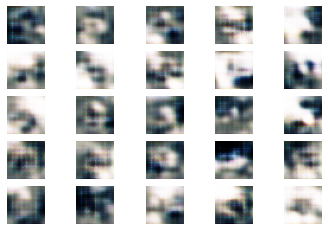

In [96]:
latent_points = generate_latent_points(100, 25)  #Latent dim and n_samples
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

import numpy as np
X = (X*255).astype(np.uint8)

# plot the result
show_plot(X, 5)